# Long Lived Particle Search @ CMS
## Cursory Analysis Notebook

Author - Paul Simmerling

Contact - psimmerl@caltech.edu

---

### Plots Wanted:

Two DataFrames (ALL PLOTS COMPARE THESE TWO):
* Inclusive (raw data)
  * ROOT.kBlue
* with MET cut (MET > 200 GeV, old analysis)
  * ROOT.kRed

* Reproduce cut-flow and efficiencies of the standard MET>200 analysis
* Remove MET>200 cut, then check which kinematic effects are changed:
  * Impact on LLP pT, and LLP energy (gen-level)
  * Change in Cluster efficiency
  * Change in ClusterSize shape
  * Change in deltaPhi (MET , cluster) distribution
  * What’s the MET distribution after requiring at least one cluster with clusterSize > 200 (or whatever passes the trigger)
  * What’s the fraction of events with CSC-CSC, DT-CSC, a single CSC cluster only
  * Plot distribution of cluster ID cut variables ( NStation, MaxStation )



gHiggsE
gHiggsEta
gHiggsPhi
gHiggsPt


cscRechitCluster_match_gLLP_e


---

### Data Driven Background Estimation

DeltaPhi vs N_{rechits}

See christina slide in the short presentation

In [1]:
# Generated LLP Kinematics
# Generated Higgs Kinematics
## P_{t}, 0 to 850
# Cluster Efficiency vs Z Decay Position, efficiency = cscRechitCluster_match_gLLP_decay_z / gLLP_decay_vertex_z
# Cluster Efficiency vs r Decay Position, efficiency = cscRechitCluster_match_gLLP_decay_r / gLLP_decay_vertex_r
# N_{hits} cscRechitClusterSize, 0 to 2000 or 3000
  # MET After At least one cluster with ClusterSize > 200
# R Decay Position vs Z Decay Position, (Z=[400, 1100], R=[100, 750])
  # Signal Efficiency
# DeltaPhi, 0 to 3.25
# ctau

# Cluster Time (Background rejection), -80 to 80ns
# N_{stations}, cscRechitClusterNStation10, 0 to 5
# Cluster Eta, 0.8 to 2
# Avg Station Number, 0 to 5
# Max Station Number, 0 to 5

# Fraction of events with:
  # CSC-CSC, DT-CSC, DT-DT, single DT, and single CSC

# Table version of NStations



In [2]:
%load_ext autoreload
%autoreload 2

import ROOT as rt
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt

from src import CMS_lumi, tdrstyle
from src.histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

tdr = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

rt.gStyle.SetOptFit(1011)
rt.gStyle.SetOptStat(0)

wH = 1
Z_MASS = 91.2
gc = []

print(sys.version)


Welcome to JupyROOT 6.26/02
3.9.15 (main, Oct 12 2022, 19:14:37) 
[GCC 11.2.0]


In [3]:
class BetterRDataFrame(rt.RDataFrame):
  def Histo1DP(model, vname):
    pass
    # data = self.data #fix later
    # np.percentile()
    # self.Histo1D

/tmp/ipykernel_6365/4117538417.py:1: RuntimeWarning: class "ROOT::RDataFrame" has no virtual destructor
  class BetterRDataFrame(rt.RDataFrame):


In [4]:
data_year = 'full'
years = ['Run3_Fall22']
fpath = 'data/raw/ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_59740pb_weighted.root'
tree_name = 'MuonSystem'

rdf_raw = rt.RDataFrame(tree_name, fpath)
rdf_cut = rdf_raw.Filter('met > 200')
vals = 'cut'

lat = rt.TLatex()
lat.SetTextSize(0.04)
lat.SetTextAlign(11)

print(rdf_cut.Count().GetValue() / rdf_raw.Count().GetValue())

0.010508032128514056


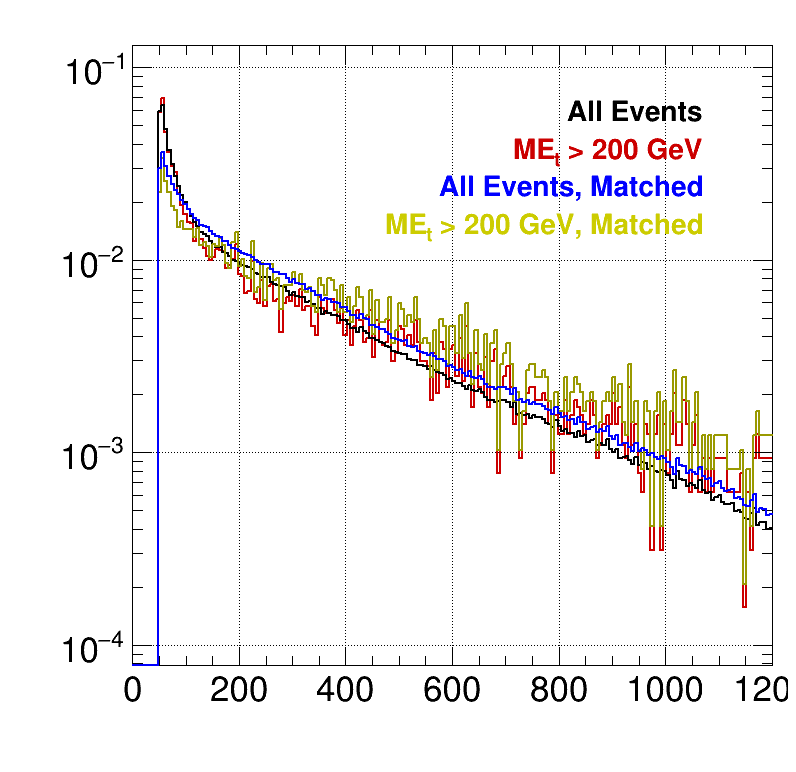

In [5]:
c = rt.TCanvas('c','c',800,800); c.Divide(1,1); c.Draw()
lat.SetTextAlign(31)

c.cd(1).SetGrid(1)
c.cd(1).SetLogy(1)
v = 'cscRechitClusterSize'
hh_raw = rdf_raw.Histo1D(('cscRechitClusterSize', 'cscRechitClusterSize', 200, 0, 1200), v)
hh_cut = rdf_cut.Histo1D(('cscRechitClusterSize', 'cscRechitClusterSize', 200, 0, 1200), v)
hh_raw.SetLineColor(rt.kBlack)
hh_cut.SetLineColor(rt.kRed+1)

hh_cut.DrawNormalized('same')
hh_raw.DrawNormalized('same')
gc.append(hh_raw)
gc.append(hh_cut)

lat.SetTextColor(rt.kBlack)
lat.DrawLatexNDC(0.89, 0.85, "All Events")
lat.SetTextColor(rt.kRed+1)
lat.DrawLatexNDC(0.89, 0.80, "ME_{t} > 200 GeV")


rdf_raw_matched = rdf_raw.Filter('cscRechitCluster_match_gLLP[0] > 0.')
rdf_cut_matched = rdf_cut.Filter('cscRechitCluster_match_gLLP[0] > 0.')

hh_raw = rdf_raw_matched.Histo1D(('cscRechitClusterSize', 'cscRechitClusterSize', 200, 0, 1200), v)
hh_cut = rdf_cut_matched.Histo1D(('cscRechitClusterSize', 'cscRechitClusterSize', 200, 0, 1200), v)
hh_raw.SetLineColor(rt.kBlue)
hh_cut.SetLineColor(rt.kYellow+2)

hh_cut.DrawNormalized('same')
hh_raw.DrawNormalized('same')
gc.append(hh_raw)
gc.append(hh_cut)

lat.SetTextColor(rt.kBlue)
lat.DrawLatexNDC(0.89, 0.75, "All Events, Matched")
lat.SetTextColor(rt.kYellow+1)
lat.DrawLatexNDC(0.89, 0.70, "ME_{t} > 200 GeV, Matched")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


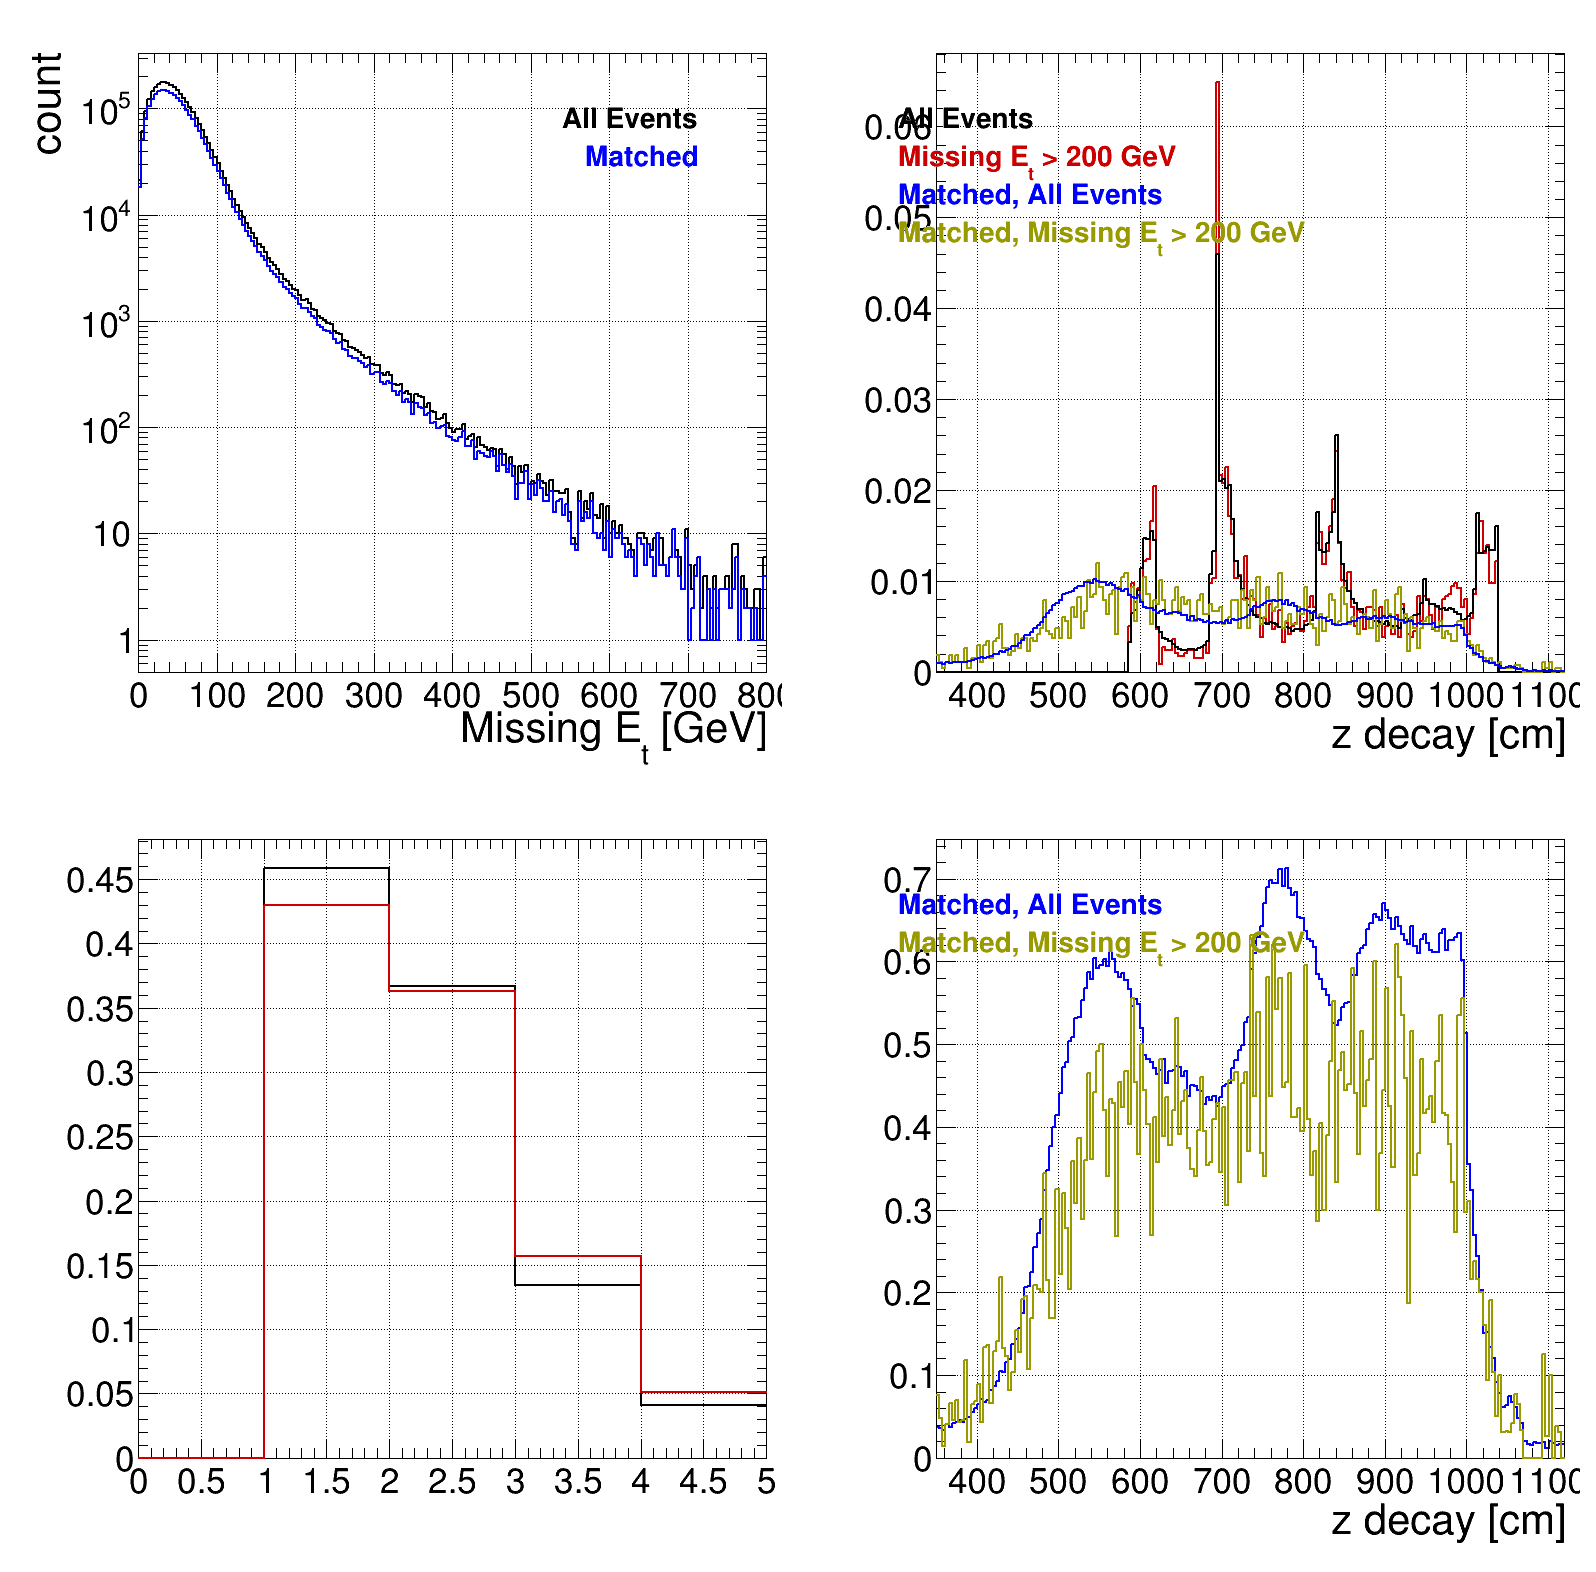

In [6]:
c = rt.TCanvas('c','c',2*800,2*800); c.Divide(2,2); c.Draw()
lat.SetTextAlign(31)

c.cd(1).SetLogy()
c.cd(1).SetGrid(1)
hMET = rdf_raw.Histo1D(('hmet', 'Missing E_{t};Missing E_{t} [GeV];count', 200, 0, 800), 'met')
hMET.Draw('same')
hMET.SetLineWidth(2)
hMET.SetLineColor(rt.kBlack)

hMET_matched = rdf_raw_matched.Histo1D(('hmet', 'Missing E_{t};Missing E_{t} [GeV];count', 200, 0, 800), 'met')
hMET_matched.Draw('same')
hMET_matched.SetLineWidth(2)
hMET_matched.SetLineColor(rt.kBlue)


lat.SetTextColor(rt.kBlack)
lat.DrawLatexNDC(0.89, 0.85, "All Events")
lat.SetTextColor(rt.kBlue)
lat.DrawLatexNDC(0.89, 0.80, "Matched")

########################

lat.SetTextAlign(11)

c.cd(3).SetGrid(1)
hh_raw = rdf_raw.Histo1D(('hcscRechitClusterNStation', 'hcscRechitClusterNStation', 5, 0, 5), 'cscRechitClusterNStation10')
hh_cut = rdf_cut.Histo1D(('hcscRechitClusterNStation', 'hcscRechitClusterNStation', 5, 0, 5), 'cscRechitClusterNStation10')
hh_raw.SetLineColor(rt.kBlack)
hh_cut.SetLineColor(rt.kRed+1)

hh_raw.DrawNormalized('same')
hh_cut.DrawNormalized('same')
gc.append(hh_raw)
gc.append(hh_cut)

########################

c.cd(2).SetGrid(1)
v = 'cscRechitClusterZ'
sv = 'cscRechitCluster_match_gLLP_decay_z'

hhr_raw = rdf_raw.Histo1D(('h'+v, v+';z decay [cm]', 200, 350, 1120), v)
hhr_cut = rdf_cut.Histo1D(('h'+v, v+';z decay [cm]', 200, 350, 1120), v)
hhs_raw = rdf_raw.Histo1D(('h'+sv, sv+';z decay [cm]', 200, 350, 1120), sv)
hhs_cut = rdf_cut.Histo1D(('h'+sv, sv+';z decay [cm]', 200, 350, 1120), sv)

hhr_raw.SetLineColor(rt.kBlack)
hhr_cut.SetLineColor(rt.kRed+1)
hhs_raw.SetLineColor(rt.kBlue)
hhs_cut.SetLineColor(rt.kYellow+2)

hhr_cut.DrawNormalized('same')
hhr_raw.DrawNormalized('same')
hhs_cut.DrawNormalized('same')
hhs_raw.DrawNormalized('same')
gc.append(hhr_raw)
gc.append(hhr_cut)
gc.append(hhs_raw)
gc.append(hhs_cut)

lat.SetTextColor(rt.kBlack)
lat.DrawLatexNDC(0.11, 0.85, "All Events")
lat.SetTextColor(rt.kRed+1)
lat.DrawLatexNDC(0.11, 0.80, "Missing E_{t} > 200 GeV")
lat.SetTextColor(rt.kBlue)
lat.DrawLatexNDC(0.11, 0.75, "Matched, All Events")
lat.SetTextColor(rt.kYellow+2)
lat.DrawLatexNDC(0.11, 0.70, "Matched, Missing E_{t} > 200 GeV")

c.cd(4).SetGrid(1)
v = 'cscRechitClusterZ'

hhs_raw.Divide(rdf_raw.Histo1D(('h'+'gLLP_decay_vertex_z', sv+';z decay [cm]', 200, 350, 1120), 'gLLP_decay_vertex_z').GetPtr())
hhs_cut.Divide(rdf_cut.Histo1D(('h'+'gLLP_decay_vertex_z', sv+';z decay [cm]', 200, 350, 1120), 'gLLP_decay_vertex_z').GetPtr())

hhs_raw.SetLineColor(rt.kBlue)
hhs_cut.SetLineColor(rt.kYellow+2)

hhs_raw.Draw('same')
hhs_cut.Draw('same')

hhs_cut.SetTitle('CSC Z Decay Efficiency')
hhs_raw.SetTitle('CSC Z Decay Efficiency')
gc.append(hhs_raw)
gc.append(hhs_cut)

lat.SetTextColor(rt.kBlue)
lat.DrawLatexNDC(0.11, 0.85, "Matched, All Events")
lat.SetTextColor(rt.kYellow+2)
lat.DrawLatexNDC(0.11, 0.80, "Matched, Missing E_{t} > 200 GeV")

# ff = rt.TF1('ff','(x>0)*TMath::Power(abs(x-0), [3]) * TMath::Exp( [4]+[5]*x+[6]*x*x )', 0, 200)
# hMET.Fit(ff, 'R')

# efficiency = cscRechitCluster_match_gLLP_decay_z / gLLP_decay_vertex_z
# efficiency = cscRechitCluster_match_gLLP_decay_r / gLLP_decay_vertex_r

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


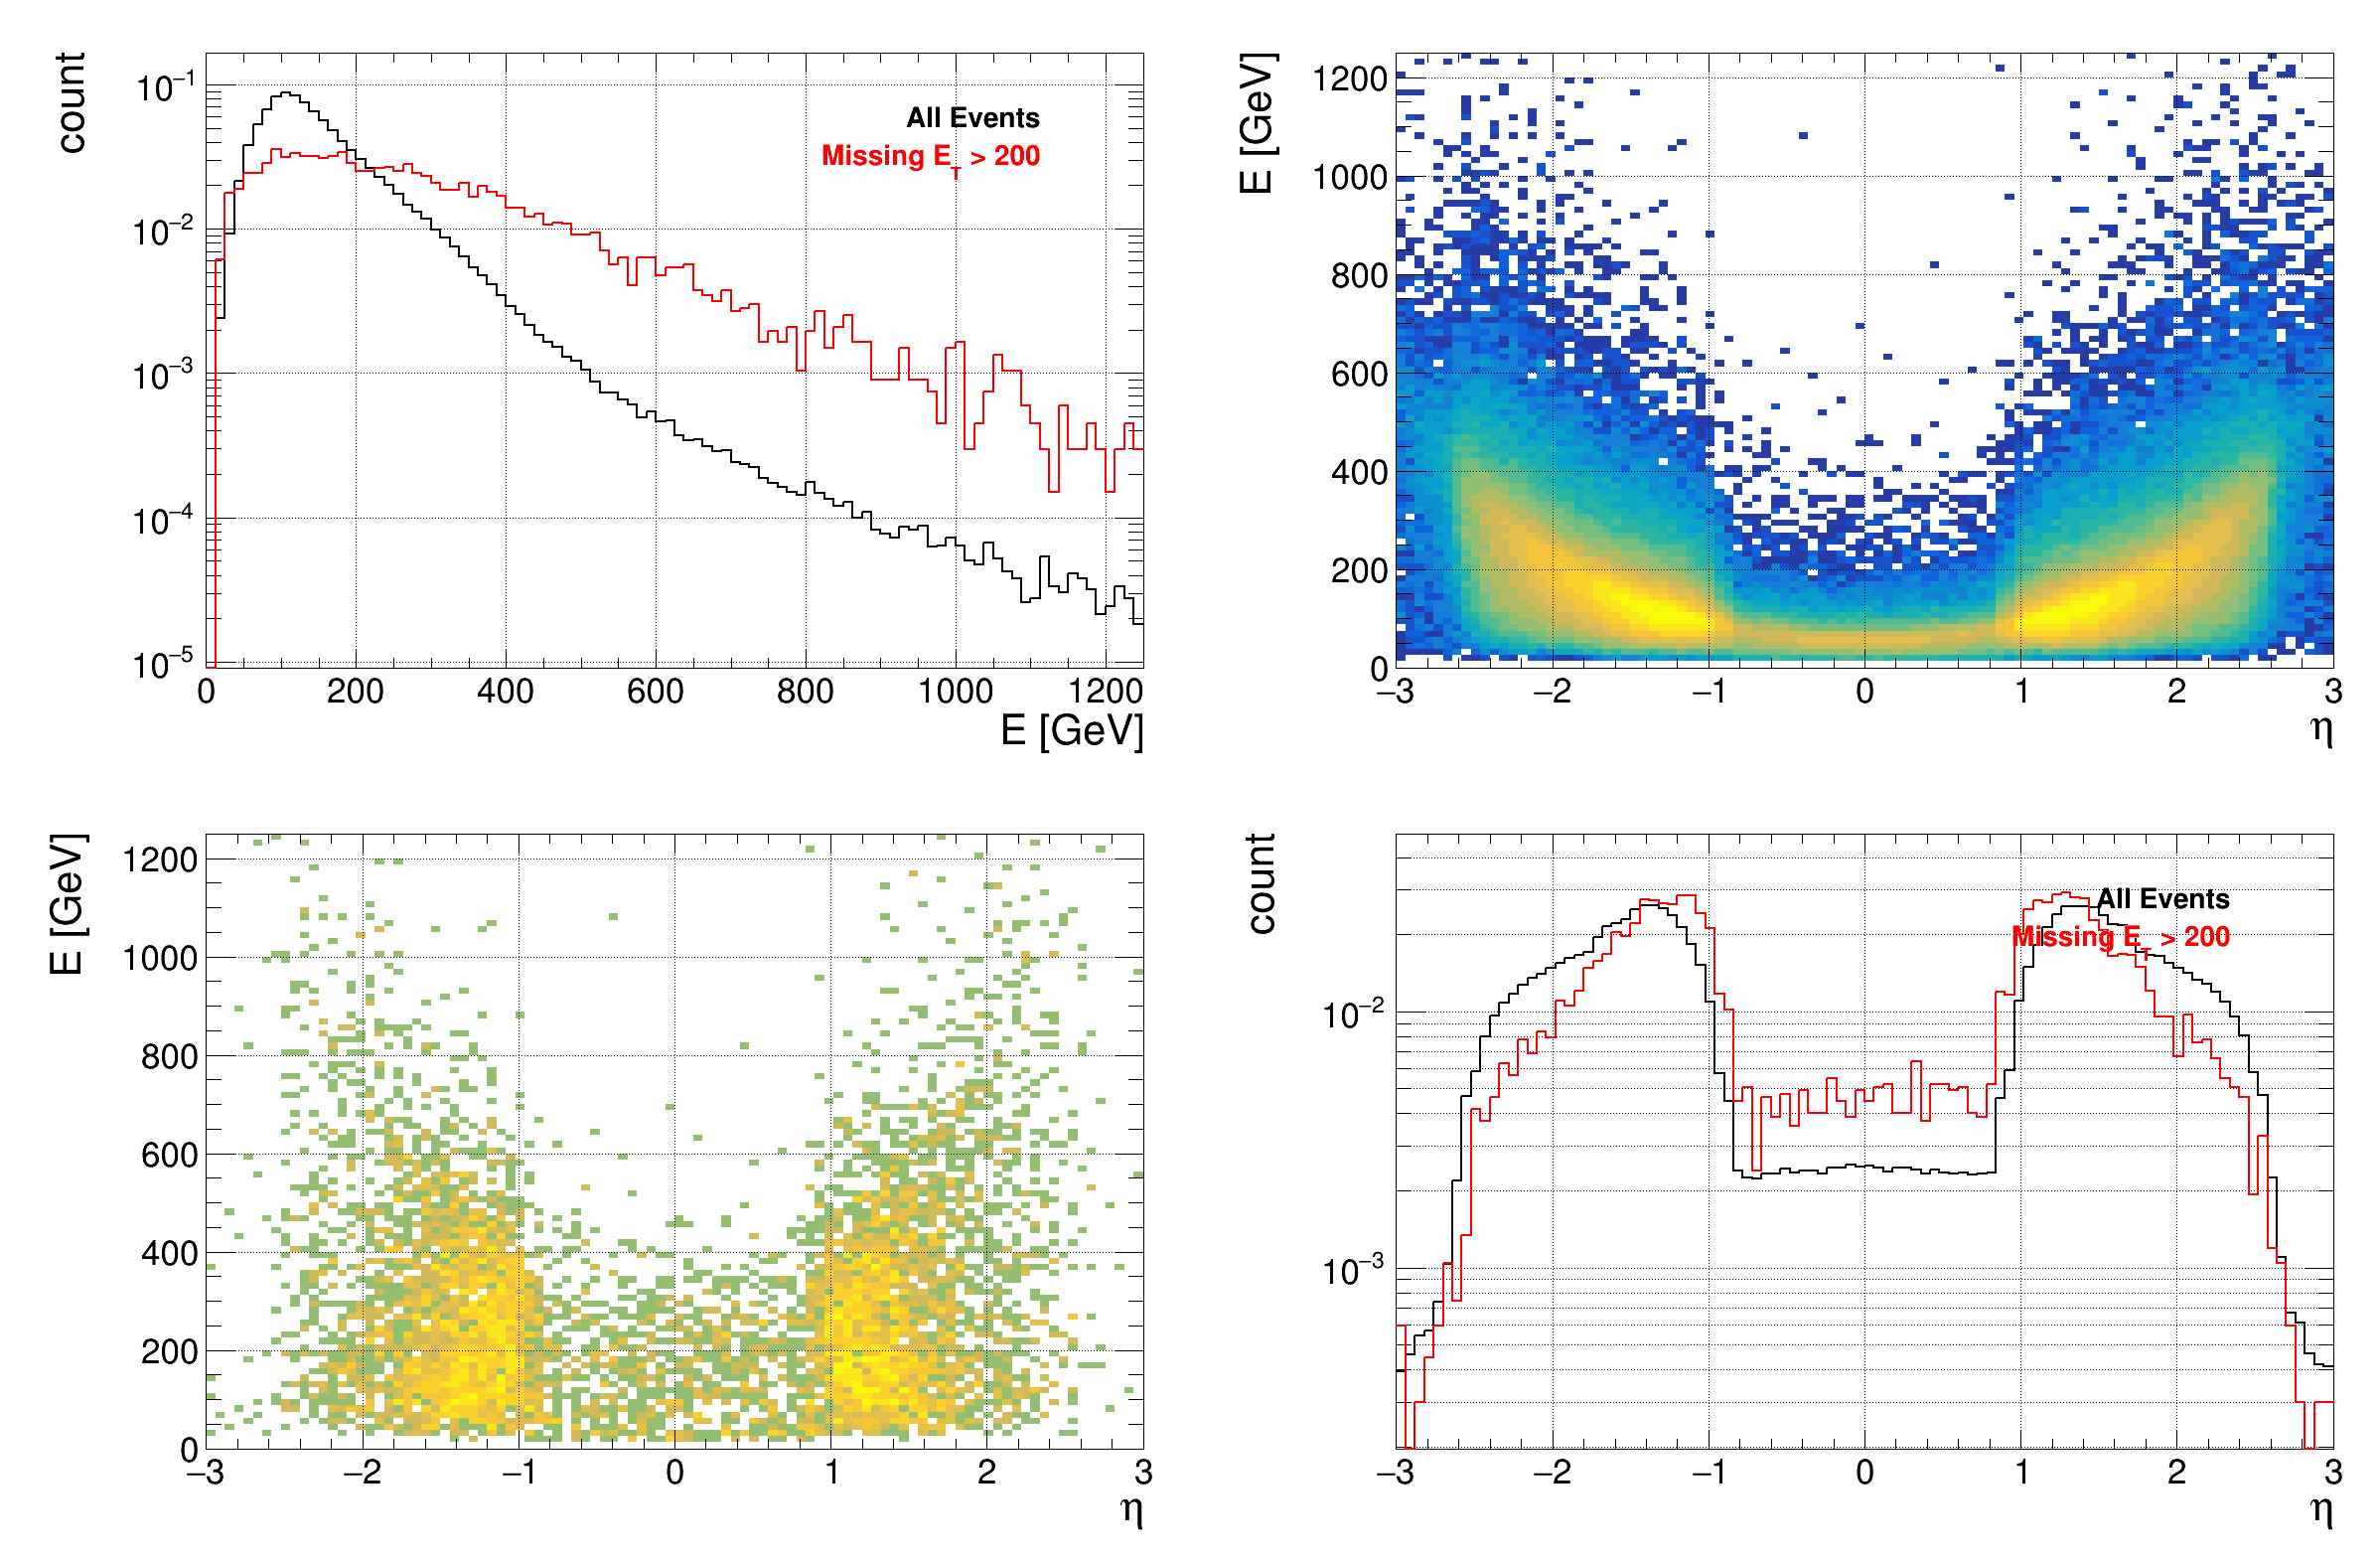

In [7]:
c = rt.TCanvas('c','c',2*1200,2*800); c.Divide(2,2); c.Draw()
lat.SetTextAlign(31)

e_bins = (100, 0, 1250)
eta_bins = (100, -3, 3)
########################

c.cd(1).SetLogy()
c.cd(1).SetGrid(1)
hist_info = (('he_llp', 'LLP Energy;E [GeV];count', *e_bins), 'cscRechitCluster_match_gLLP_e')

hE_LLP = rdf_raw.Histo1D(*hist_info)
hE_LLP.SetLineWidth(2)
hE_LLP.SetLineColor(rt.kBlack)
hE_LLP.DrawNormalized('same')

hE_LLP_cut = rdf_cut.Histo1D(*hist_info)
hE_LLP_cut.SetLineWidth(2)
hE_LLP_cut.SetLineColor(rt.kRed)
hE_LLP_cut.DrawNormalized('same')

lat.SetTextColor(rt.kBlack)
lat.DrawLatexNDC(0.89, 0.85, "All Events")
lat.SetTextColor(rt.kRed)
lat.DrawLatexNDC(0.89, 0.80, "Missing E_{T} > 200")

########################

c.cd(4).SetLogy()
c.cd(4).SetGrid(1)
hist_info = (('heta_llp', 'LLP #eta;#eta;count', *eta_bins), 'cscRechitCluster_match_gLLP_eta')
hEta_LLP = rdf_raw.Histo1D(*hist_info)
hEta_LLP.SetLineWidth(2)
hEta_LLP.SetLineColor(rt.kBlack)
hEta_LLP.DrawNormalized('same')

hEta_LLP_cut = rdf_cut.Histo1D(*hist_info)
hEta_LLP_cut.SetLineWidth(2)
hEta_LLP_cut.SetLineColor(rt.kRed)
hEta_LLP_cut.DrawNormalized('same')

lat.SetTextColor(rt.kBlack)
lat.DrawLatexNDC(0.89, 0.85, "All Events")
lat.SetTextColor(rt.kRed)
lat.DrawLatexNDC(0.89, 0.80, "Missing E_{T} > 200")

########################

hlabel, htitle = 'heta_llp_e_llp', 'LLP Energy vs #eta'
hxylabels, hxybins = ';#eta;E [GeV]', (*eta_bins, *e_bins)
hxyfeats = ('cscRechitCluster_match_gLLP_eta', 'cscRechitCluster_match_gLLP_e')

c.cd(2).SetLogz()
c.cd(2).SetGrid(1)
hist_info = ((hlabel, htitle+hxylabels, *hxybins), *hxyfeats)
hEta_LLP_E_LLP = rdf_raw.Histo2D(*hist_info)
hEta_LLP_E_LLP.Draw('col')

c.cd(3).SetLogz()
c.cd(3).SetGrid(1)
hist_info = ((hlabel, htitle+', Missing E_{t} > 200'+hxylabels, *hxybins), *hxyfeats)
hEta_LLP_E_LLP_cut = rdf_cut.Histo2D(*hist_info)
hEta_LLP_E_LLP_cut.Draw('col')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


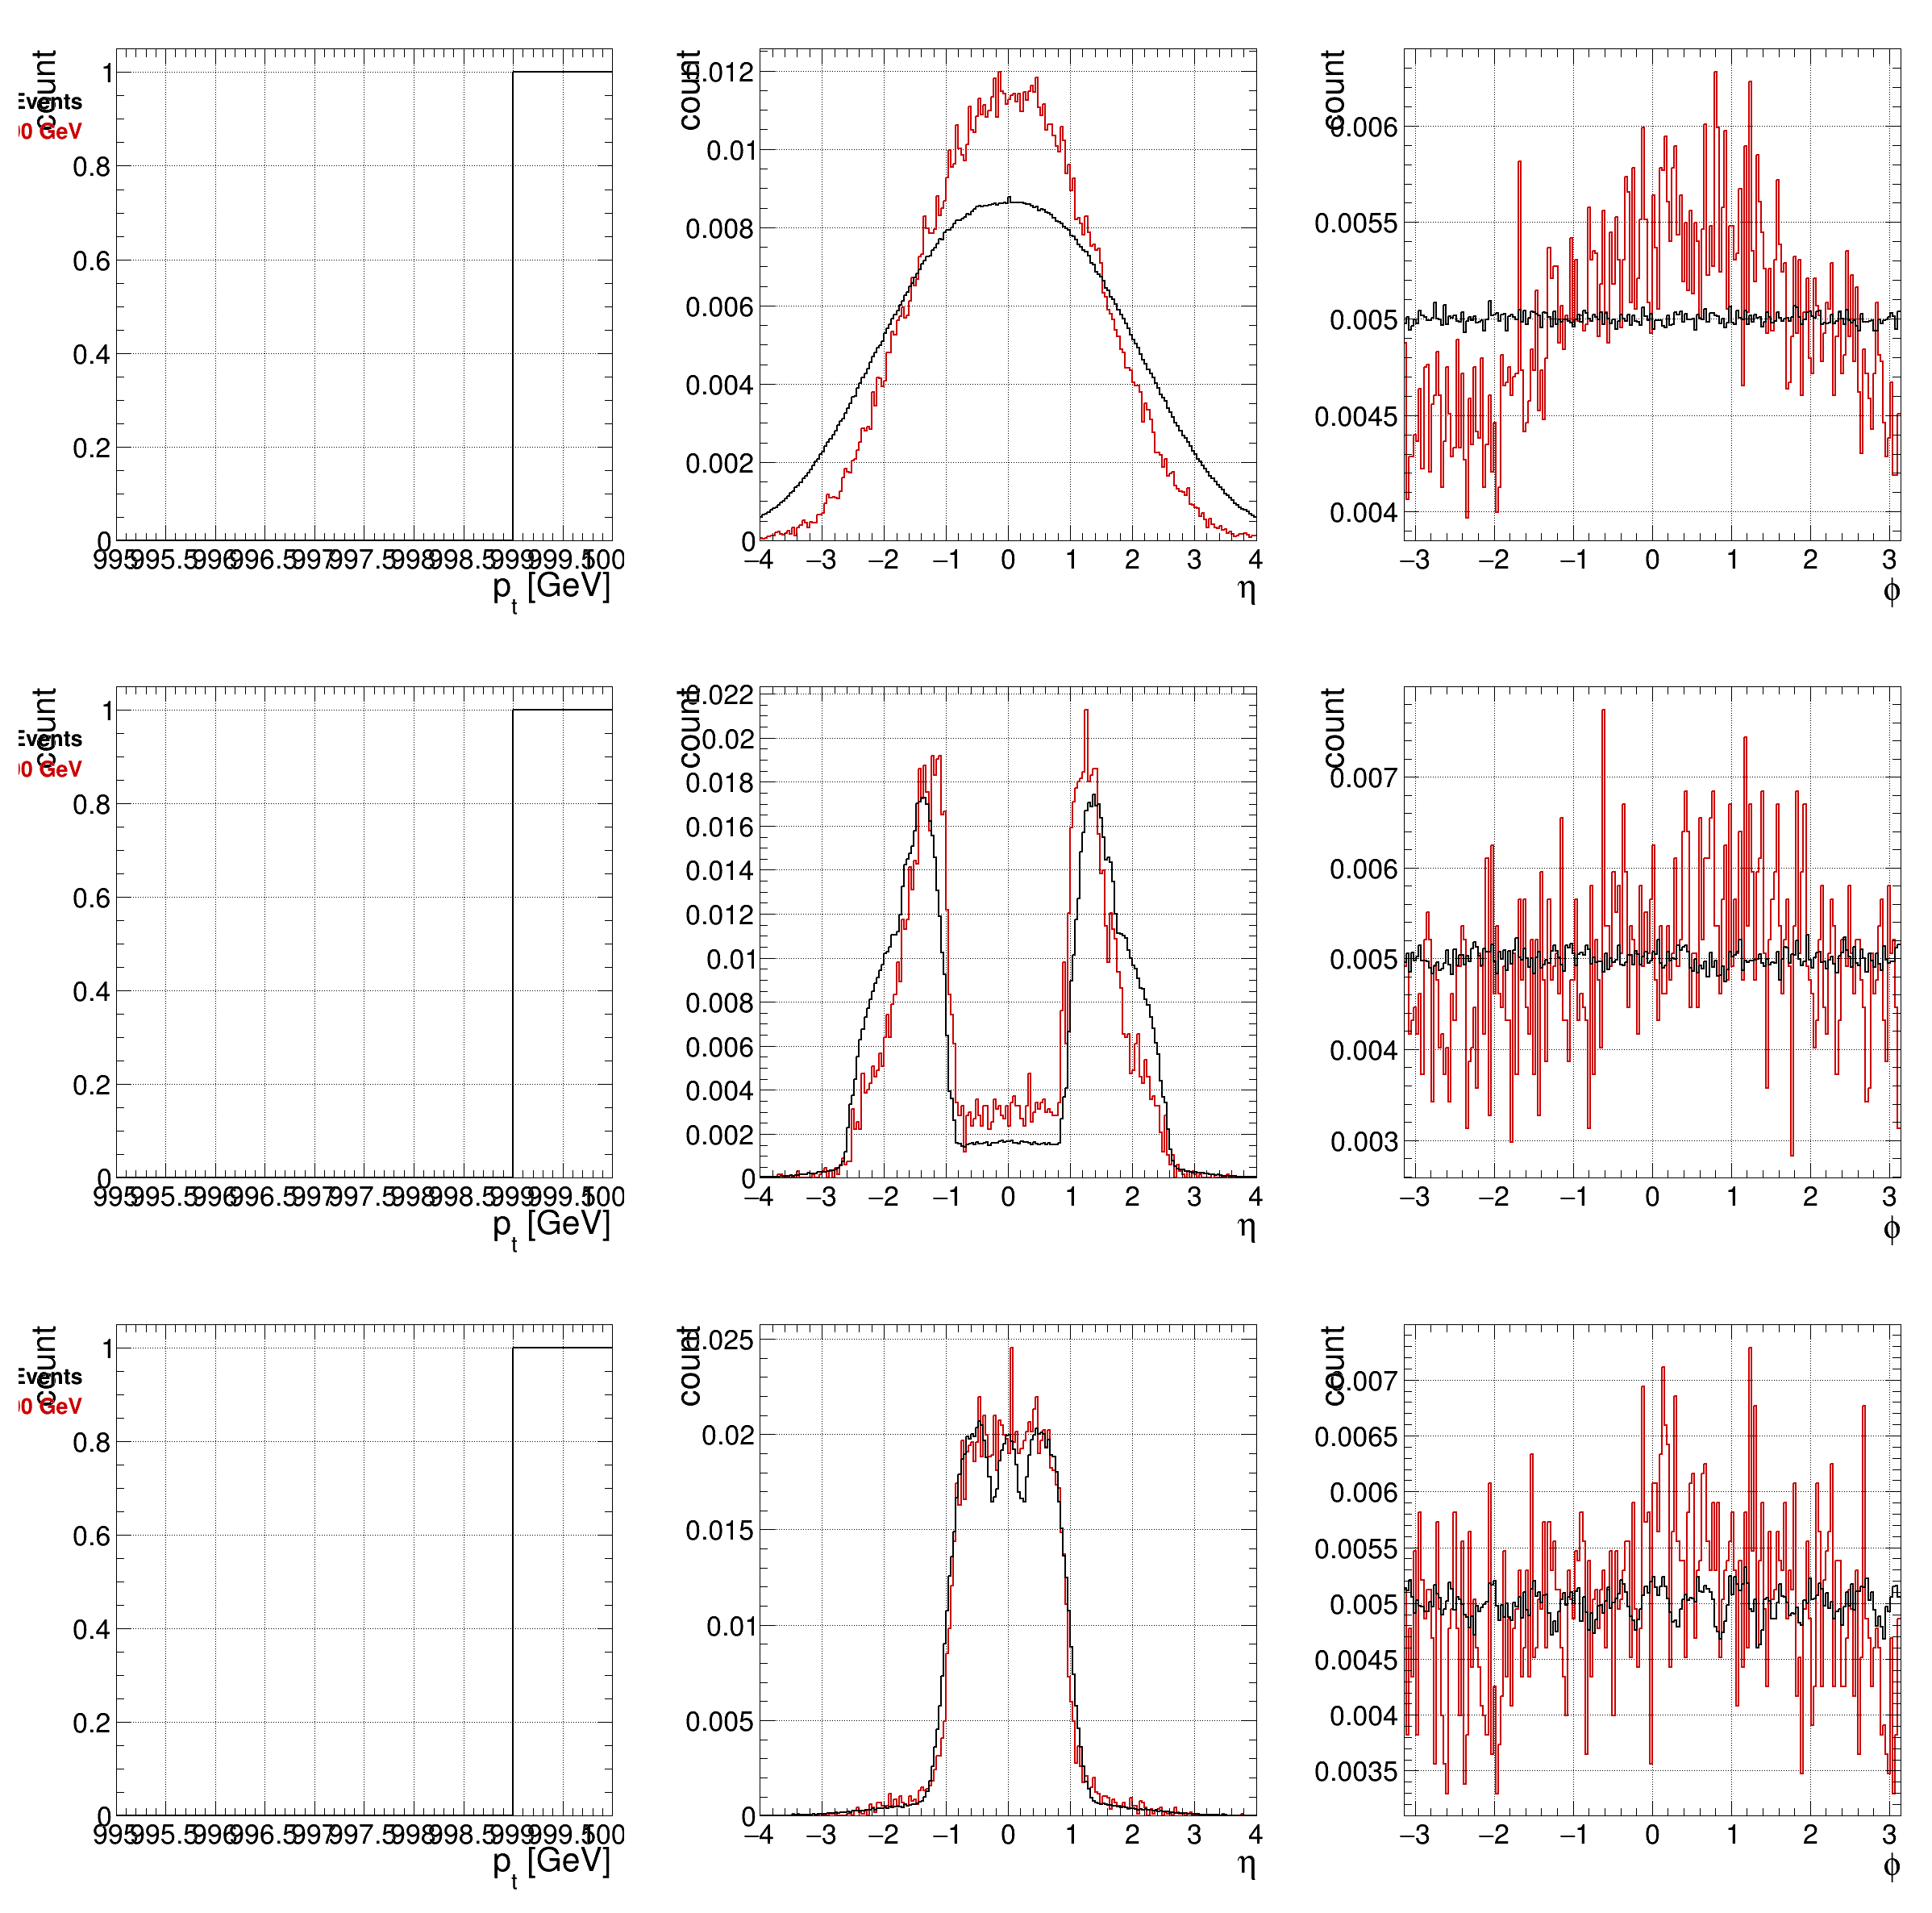

In [8]:
c = rt.TCanvas('c','c',3*800,3*800); c.Divide(3,3); c.Draw()

# cscRechitCluster_match_gLLP_pt

vs = [id+'_'+p for id in ['gLLP', 'cscRechitCluster_match_gLLP', 'dtRechitCluster_match_gLLP'] for p in ['pt', 'eta', 'phi']]
tts = [id+' '+p for id in ['gLLP', 'CSC', 'DT'] for p in ['P_{t}', '#eta', '#phi']]
xls = 3*['p_{t} [GeV]', '#eta', '#phi']
yls = 3*['count', 'count', 'count']
bbs = 3*[(5, 995, 1000), (200, -4, 4), (200, -3.14, 3.14)]

for i, (v, tt, xl, yl, bb) in enumerate(zip(vs, tts, xls, yls, bbs)):
  c.cd(i+1).SetGrid(1)
  hh_raw = rdf_raw.Histo1D(('h'+v, f'{tt};{xl};{yl}', *bb), v)
  hh_cut = rdf_cut.Histo1D(('h'+v, f'{tt};{xl};{yl}', *bb), v)

  hh_raw.SetLineWidth(2)
  hh_cut.SetLineWidth(2)
  hh_raw.SetLineColor(rt.kBlack)
  hh_cut.SetLineColor(rt.kRed+1)

  hh_cut.DrawNormalized('same')
  hh_raw.DrawNormalized('same')
  gc.append(hh_raw)
  gc.append(hh_cut)

  if 'pt' in v:
    lat.SetTextColor(rt.kBlack)
    lat.DrawLatexNDC(0.11, 0.85, "All Events")
    lat.SetTextColor(rt.kRed+1)
    lat.DrawLatexNDC(0.11, 0.80, "Missing E_{t} > 200 GeV")



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


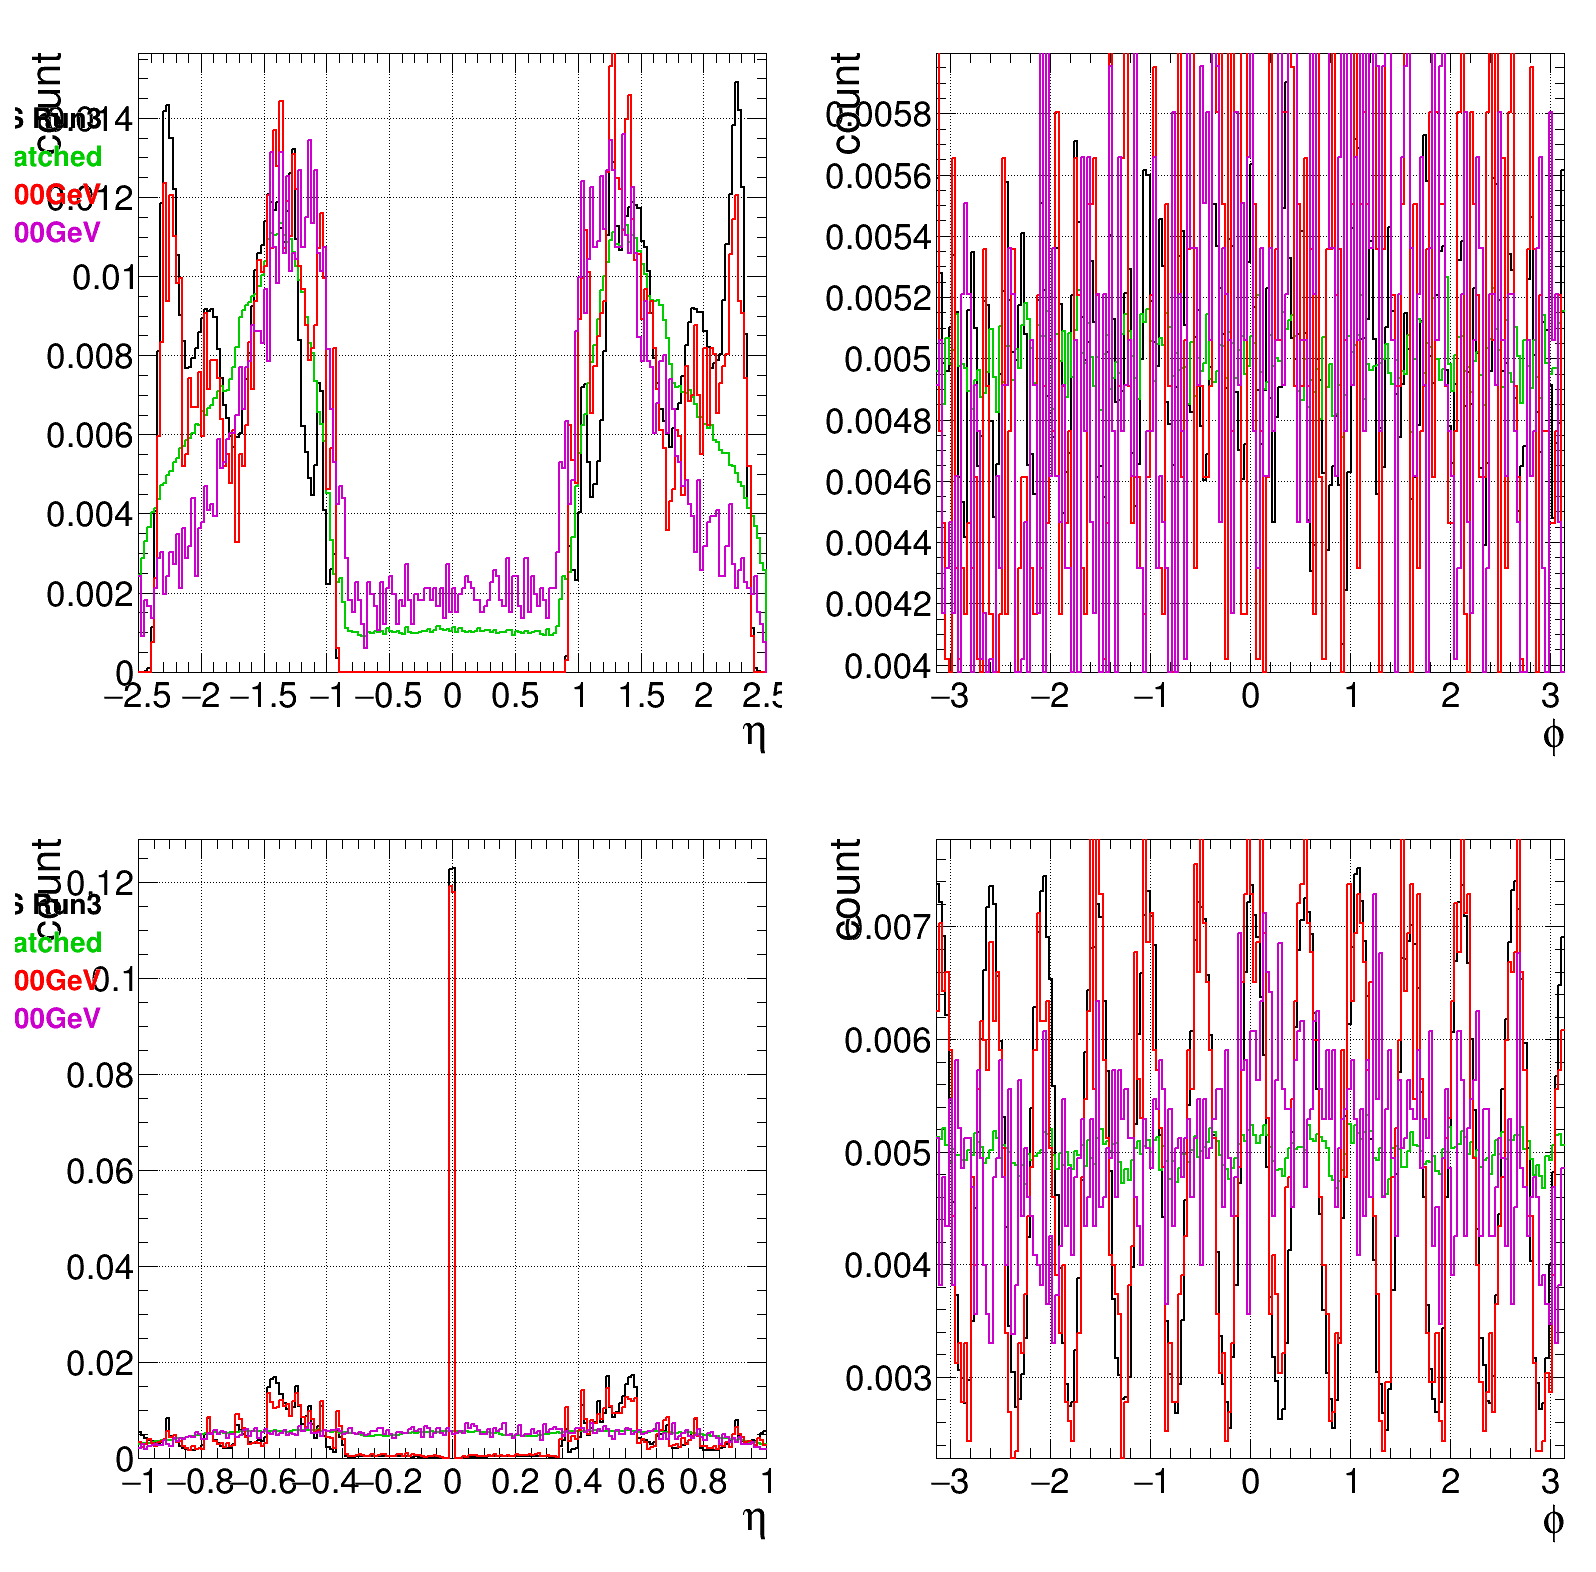

In [9]:
c = rt.TCanvas('c','c',2*800,2*800); c.Divide(2,2); c.Draw()

svs = [id+'_'+p for id in ['cscRechitCluster_match_gLLP', 'dtRechitCluster_match_gLLP'] for p in ['eta', 'phi']]
rvs = [id+''+p for id in ['cscRechitCluster', 'dtRechitCluster'] for p in ['Eta', 'Phi']]
tts = [id+' '+p for id in ['CSC', 'DT'] for p in ['#eta', '#phi']]
xls = 2*['#eta', '#phi']
yls = 2*['count', 'count']
bbs = [(200, -2.5, 2.5), (200, -3.14, 3.14)] + [(200, -1, 1), (200, -3.14, 3.14)]

for i, (sv, rv, tt, xl, yl, bb) in enumerate(zip(svs, rvs, tts, xls, yls, bbs)):
  c.cd(i+1).SetGrid(1)
  hhs = rdf_raw.Histo1D(('h'+v, f'{tt};{xl};{yl}', *bb), sv)
  hhr = rdf_raw.Histo1D(('h'+v, f'{tt};{xl};{yl}', *bb), rv)

  hhr.SetLineWidth(2)
  hhs.SetLineWidth(2)
  hhr.SetLineColor(rt.kBlack)
  hhs.SetLineColor(rt.kGreen+1)
  # hhs.SetLineStyle(10)

  hhr.DrawNormalized('same')
  hhs.DrawNormalized('same')
  gc.append(hhs)
  gc.append(hhr)
  
  hhs = rdf_cut.Histo1D(('h'+v, f'{tt};{xl};{yl}', *bb), sv)
  hhr = rdf_cut.Histo1D(('h'+v, f'{tt};{xl};{yl}', *bb), rv)

  hhr.SetLineWidth(2)
  hhs.SetLineWidth(2)
  hhr.SetLineColor(rt.kRed)
  hhs.SetLineColor(rt.kMagenta+1)
  # hhs.SetLineStyle(10)

  hhr.DrawNormalized('same')
  hhs.DrawNormalized('same')
  gc.append(hhs)
  gc.append(hhr)

  if 'eta' in sv:
    lat.SetTextColor(rt.kBlack)
    lat.DrawLatexNDC(0.11, 0.85, "CMS Run3")
    lat.SetTextColor(rt.kGreen+1)
    lat.DrawLatexNDC(0.11, 0.80, "CMS Matched")
    lat.SetTextColor(rt.kRed)
    lat.DrawLatexNDC(0.11, 0.75, "CMS Run3, ME_{t}>200GeV")
    lat.SetTextColor(rt.kMagenta+1)
    lat.DrawLatexNDC(0.11, 0.70, "CMS Matched, ME_{t}>200GeV")



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


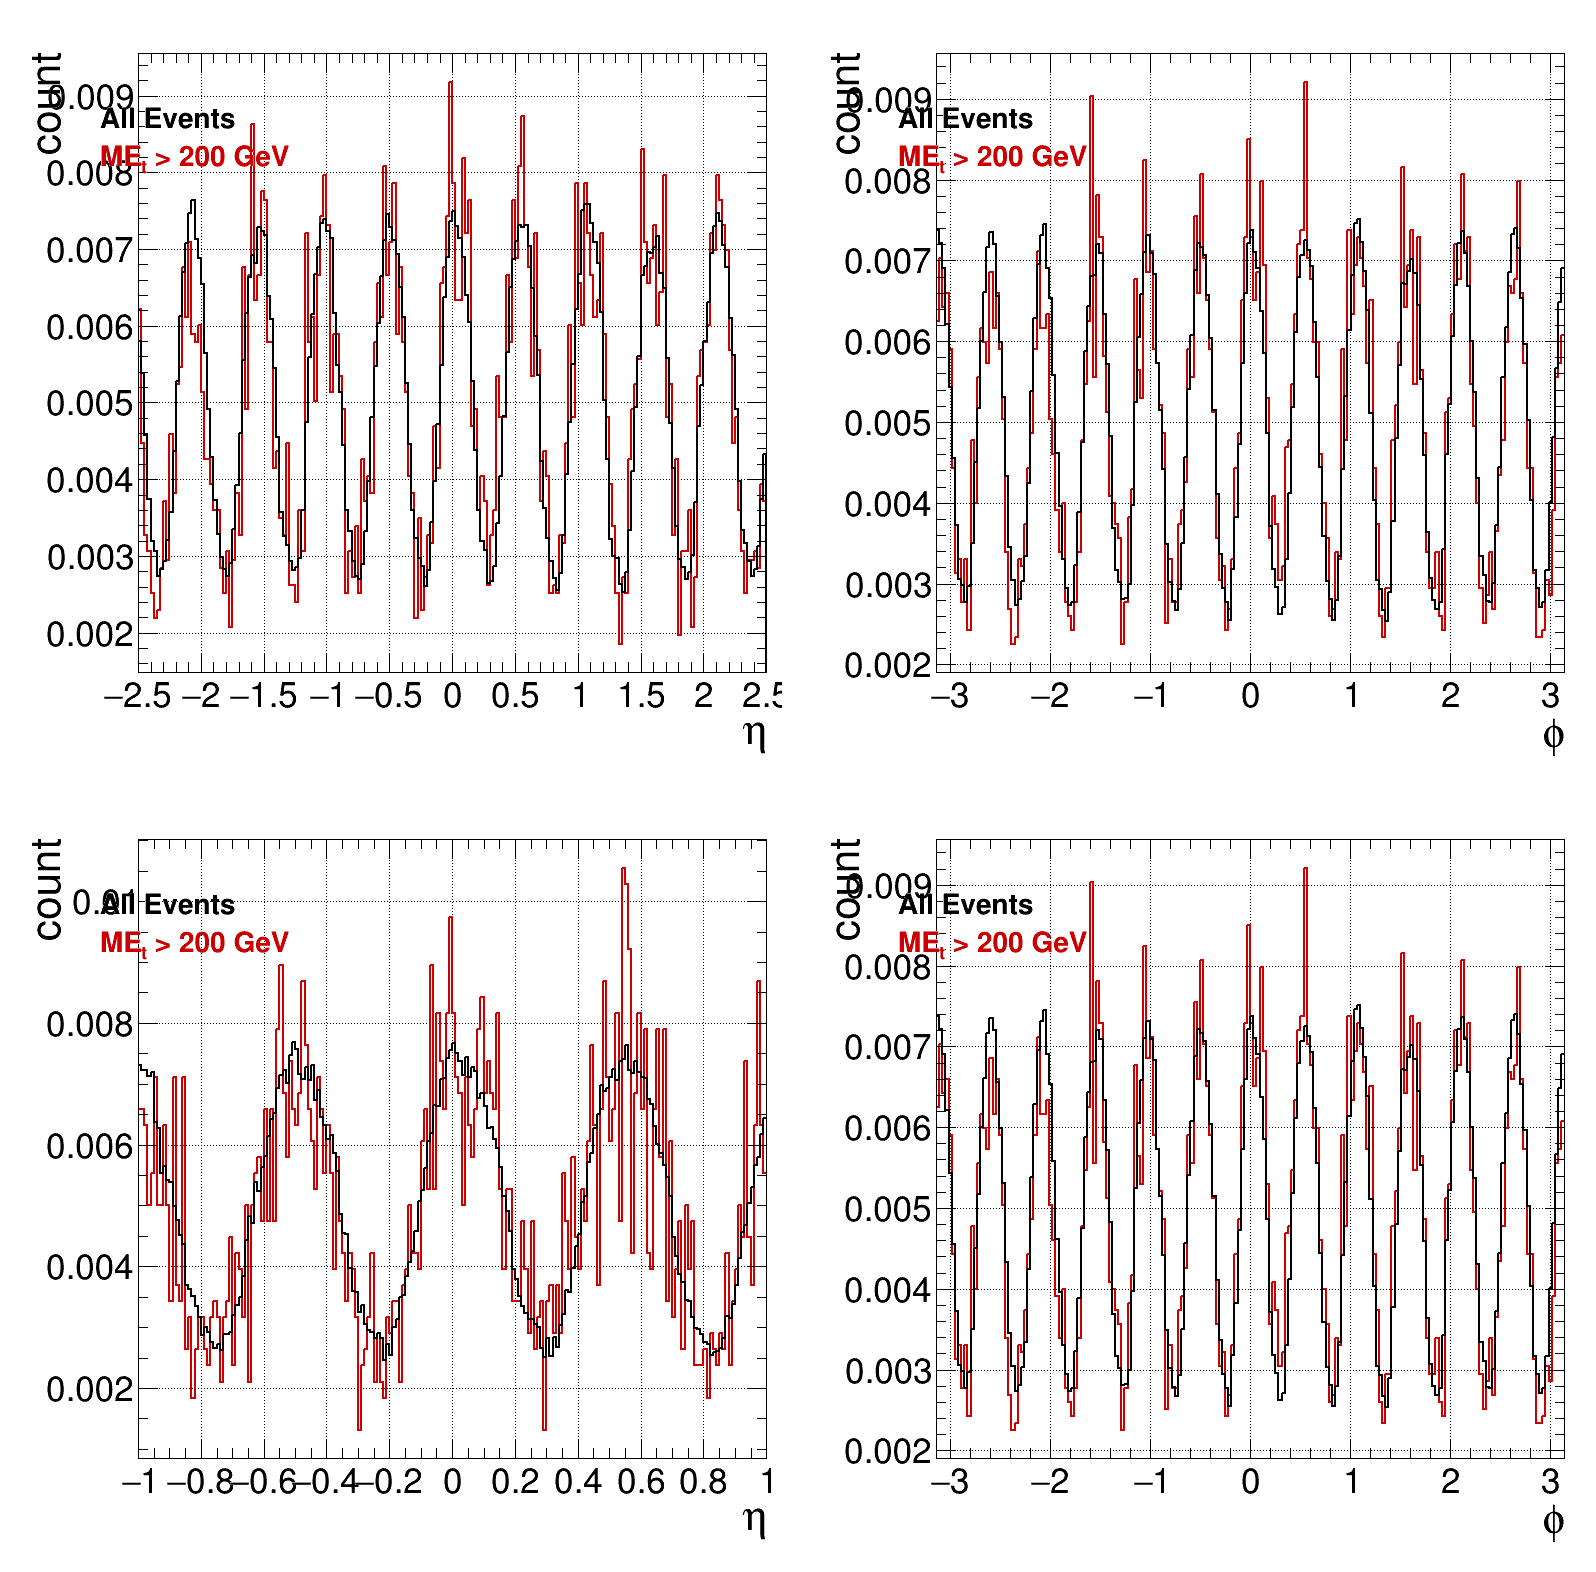

In [10]:
c = rt.TCanvas('c','c',2*800,2*800); c.Divide(2,2); c.Draw()

lat = rt.TLatex()
lat.SetTextSize(0.04)
lat.SetTextAlign(11)

vs = [id+''+p+'Spread' for id in ['cscRechitCluster', 'dtRechitCluster'] for p in ['Eta', 'Phi']]
tts = [id+' '+p+' Spread' for id in ['CSC', 'DT'] for p in ['#eta', '#phi']]
xls = 2*['#eta', '#phi']
yls = 2*['count', 'count']
bbs = [(200, -2.5, 2.5), (200, -3.14, 3.14)] + [(200, -1, 1), (200, -3.14, 3.14)]

for i, (v, tt, xl, yl, bb) in enumerate(zip(vs, tts, xls, yls, bbs)):
  c.cd(i+1).SetGrid(1)

  hh = rdf_cut.Histo1D(('h'+v, f'{tt};{xl};{yl}', *bb), rv)

  hh.SetLineWidth(2)
  hh.SetLineColor(rt.kRed+1)

  hh.DrawNormalized('same')
  gc.append(hh)
  
  hh = rdf_raw.Histo1D(('h'+v, f'{tt};{xl};{yl}', *bb), rv)

  hh.SetLineWidth(2)
  hh.SetLineColor(rt.kBlack)

  hh.DrawNormalized('same')
  gc.append(hh)



  lat.SetTextColor(rt.kBlack)
  lat.DrawLatexNDC(0.11, 0.85, "All Events")
  lat.SetTextColor(rt.kRed+1)
  lat.DrawLatexNDC(0.11, 0.80, "ME_{t} > 200 GeV")

